# Visualize how `OnlineDiversityPicker` works

This notebook provides visualizations for the `OnlineDiversityPicker` algorithm within Euclidean space, offering insights into the algorithm's operational mechanics. Subsequently, it employs generated fingerprints to demonstrate the algorithm's performance on a "chemical" space.

The parameters of the algorithm are:

- `n_points`: the quantity of points to be selected,
- `p`: the power of the repulsion term,
- `k_neighbors`: the number of neighbors factored into the repulsion calculation

We construct a subset $P$ of `n_points` of a large set $M$ iteratively optimizing the following objective function:

$$ \mathcal{L} (P) = \mathcal{L} (\mathbf p_1, \cdots, \mathbf p_{n \text{ points}}) = \sum_{\mathbf p, \mathbf p' \in P} \dfrac{1}{|| \mathbf p - \mathbf p' ||^p} \to \min_{P \subset M}. $$

The sum is approximated by a sum over the `k_neighbors` of each point $\mathbf p \in P$.

In [2]:
import itertools

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_blobs
from tqdm.auto import tqdm
import numpy as np
from functools import partial

from moll.core.distance import euclidean, tanimoto
from moll.core.diversity import OnlineDiversityPicker

Suppress warnings for clarity:

In [2]:
import warnings

warnings.filterwarnings("ignore")

## Euclidean Space

### A unit square

Initialize random bathes

In [3]:
batches = jax.random.uniform(jax.random.PRNGKey(0), (100, 100, 2))

Fit picker for different values of `n_points` and `k_neighbors`:

  0%|          | 0/12 [00:00<?, ?it/s]

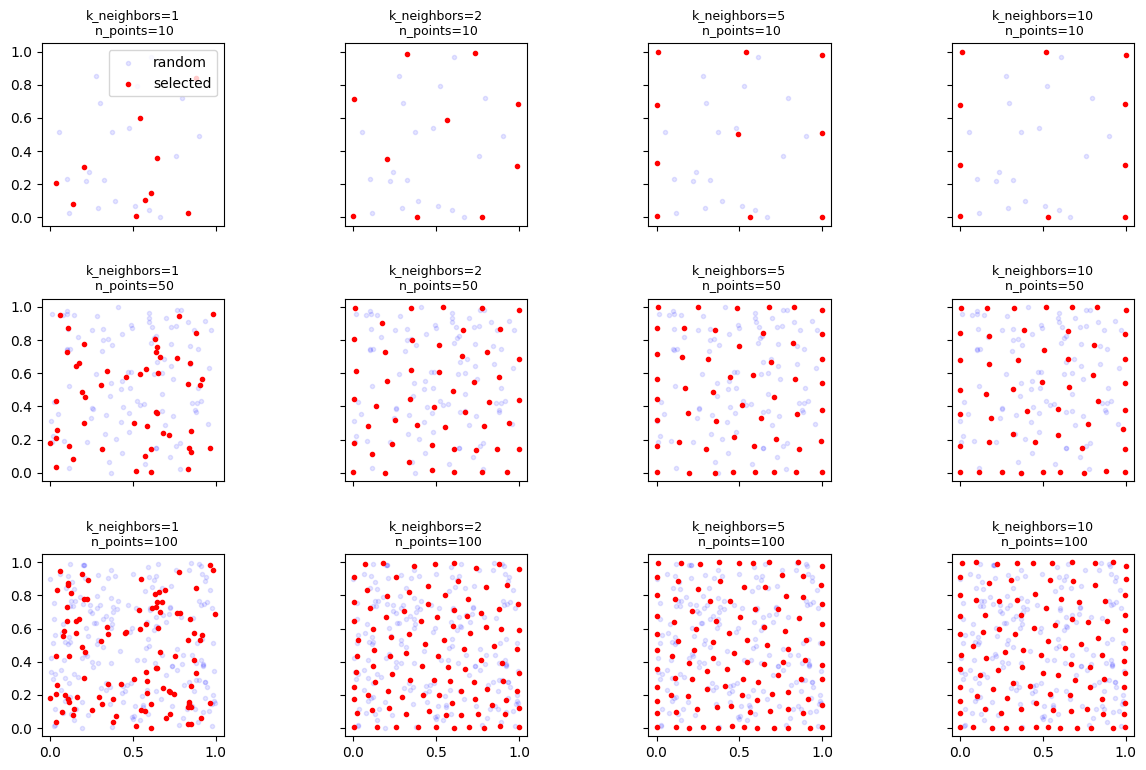

In [7]:
fig, axes = plt.subplots(3, 4, figsize=(15, 9), sharex=True, sharey=True)

n_points_list = [10, 50, 100]
k_neighbors_list = [1, 2, 5, 10]

# flatten
for (i, n_points), (j, k_neighbors) in tqdm(
    itertools.product(enumerate(n_points_list), enumerate(k_neighbors_list)),
    total=len(n_points_list) * len(k_neighbors_list),
):
    picker = OnlineDiversityPicker(
        capacity=n_points, dist_fn=euclidean, k_neighbors=k_neighbors
    )

    # Iterate over the batches
    for batch in batches:
        picker.extend(batch)

    # Get the selected points
    x_sel, y_sel = picker.points.T

    # Get the random batch points
    point, y = jax.random.choice(
        jax.random.PRNGKey(0), batches.reshape(-1, 2), (n_points, 2)
    ).T

    # Plot the selected points
    axes[i, j].scatter(point, y, c="b", marker=".", label="random", alpha=0.1)
    axes[i, j].scatter(x_sel, y_sel, c="r", marker=".", label="selected")
    axes[i, j].set_title(f"k_neighbors={k_neighbors}\n n_points={n_points}", fontsize=9)
    axes[i, j].set_aspect("equal")

    if i == 0 and j == 0:
        axes[i, j].legend()

fig.subplots_adjust(hspace=0.4)
plt.show()

Fit picker for different values of `p` and `k_neighbors`:

  0%|          | 0/25 [00:00<?, ?it/s]

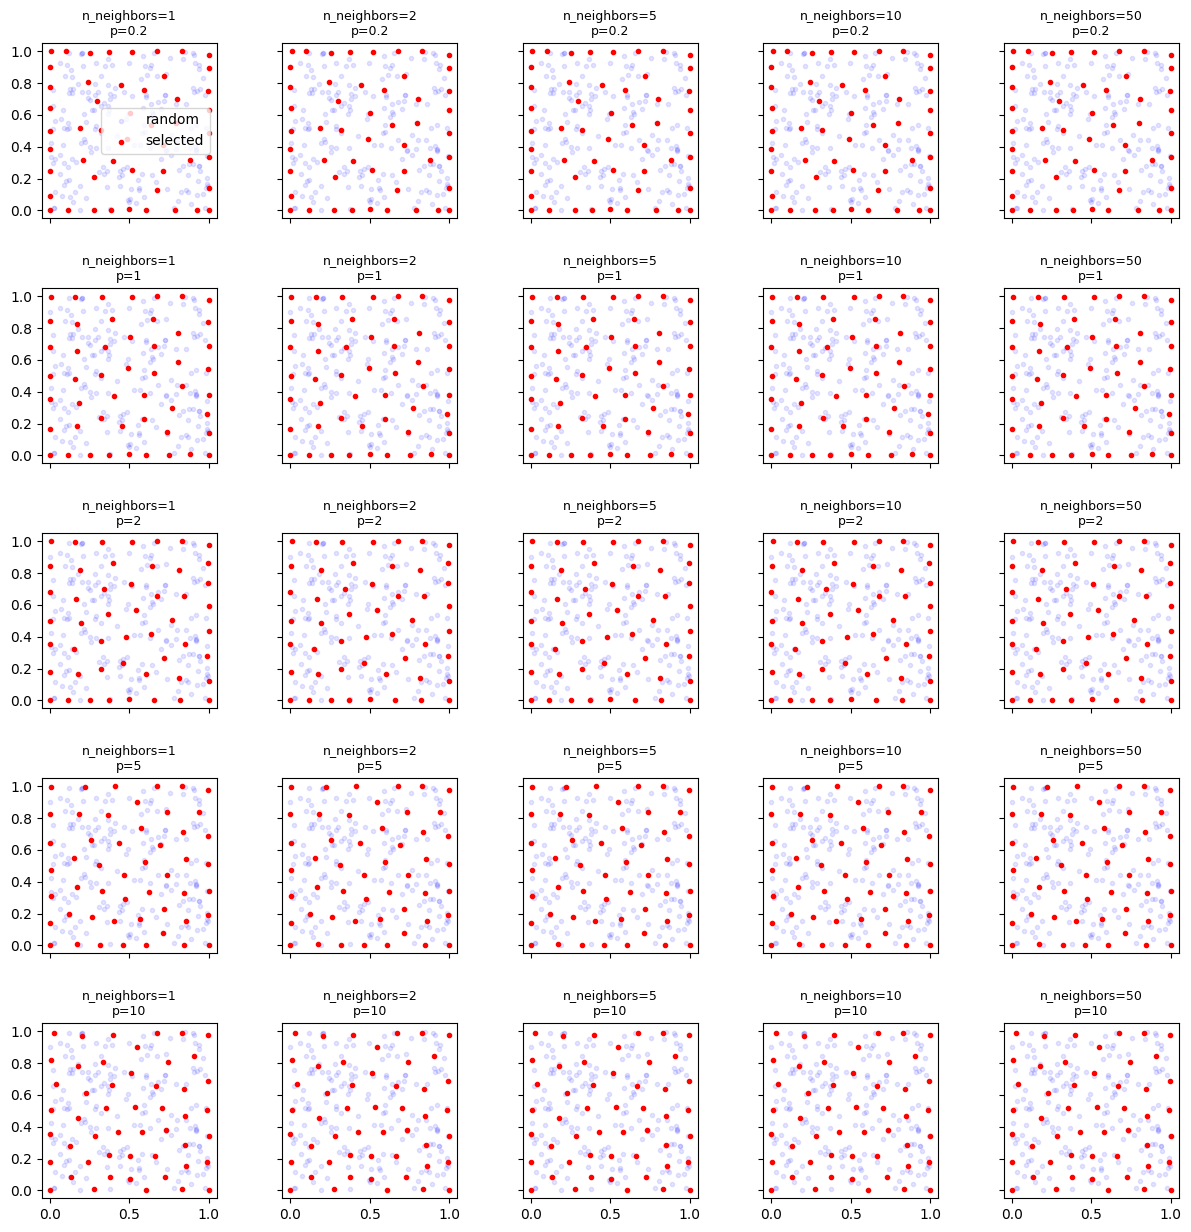

In [9]:
p_list = [0.2, 1, 2, 5, 10]
n_neighbors_list = [1, 2, 5, 10, 50]

fig, axes = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)

# flatten
for (i, p), (j, n_neighbors) in tqdm(
    itertools.product(enumerate(p_list), enumerate(n_neighbors_list)),
    total=len(p_list) * len(n_neighbors_list),
):
    picker = OnlineDiversityPicker(
        capacity=50, dist_fn=euclidean, k_neighbors=k_neighbors, p=p
    )

    # Iterate over the batches
    for batch in batches:
        picker.extend(batch)

    # Get the selected points
    x_sel, y_sel = picker.points.T

    # Get the random batch points
    point, y = jax.random.choice(
        jax.random.PRNGKey(0), batches.reshape(-1, 2), (n_points, 2)
    ).T

    # Plot the selected points
    axes[i, j].scatter(point, y, c="b", marker=".", label="random", alpha=0.1)
    axes[i, j].scatter(x_sel, y_sel, c="r", marker=".", label="selected")
    axes[i, j].set_title(f"n_neighbors={n_neighbors}\np={p}", fontsize=9)
    axes[i, j].set_aspect("equal")

    if i == 0 and j == 0:
        axes[i, j].legend()

fig.subplots_adjust(hspace=0.4)
plt.show()

### Blobs

Repeat the same procedure for spherical clusters:

In [2]:
points, _ = make_blobs(n_samples=10_000, random_state=21, centers=3)
np.random.seed(42)
np.random.shuffle(points)

NameError: name 'n_neighbors_list' is not defined

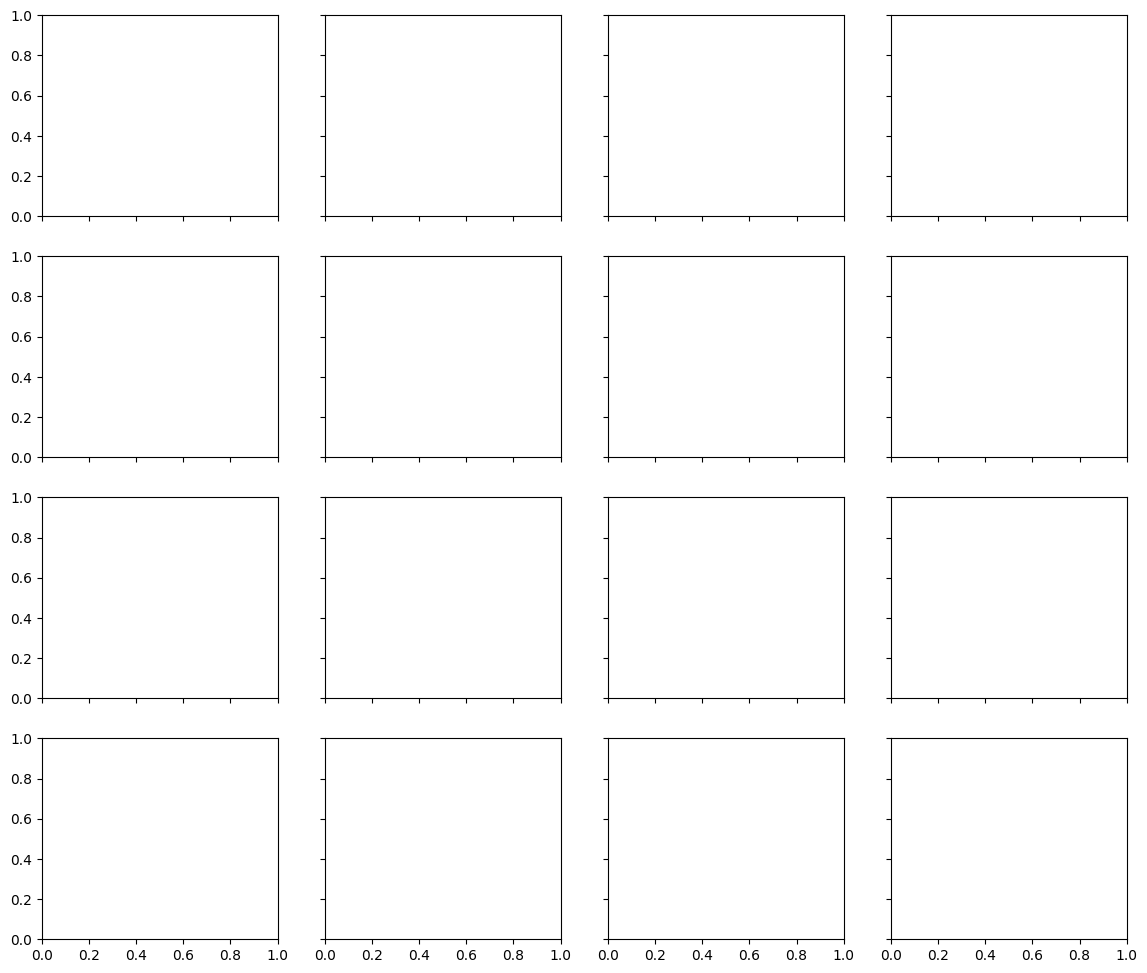

In [3]:
p_list = [0.5, 2, 5, 10]
k_neighbors_list = [1, 5, 10, 50]

fig, axes = plt.subplots(4, 4, figsize=(14, 12), sharex=True, sharey=True)

# flatten
for (i, p), (j, k_neighbors) in tqdm(
    itertools.product(enumerate(p_list), enumerate(k_neighbors_list)),
    total=len(p_list) * len(n_neighbors_list),
):
    picker = OnlineDiversityPicker(
        capacity=50, dist_fn=euclidean, k_neighbors=k_neighbors, p=p
    )

    picker.extend(points)

    # Get the selected points
    x_sel, y_sel = picker.points.T

    point, y = points.T

    # Plot the selected points
    axes[i, j].scatter(point, y, c="b", marker=".", label="original", alpha=0.1)
    axes[i, j].scatter(x_sel, y_sel, c="r", marker=".", label="selected")
    axes[i, j].set_title(f"k_neighbors={k_neighbors}\np={p}", fontsize=9)
    axes[i, j].set_aspect("equal")

    if i == 0 and j == 0:
        axes[i, j].legend()


fig.subplots_adjust(hspace=0.1)
plt.show()

## Chemical Space

Generate 10K fingerprints of length 100 using Bernoulli distribution:

In [3]:
fingerprints = jax.random.bernoulli(
    jax.random.PRNGKey(0), p=0.5, shape=(10_000, 100)
).astype(bool)

Define a function to calculate pairwise distances between fingerprints:

In [4]:
@partial(jax.jit, static_argnums=(1,))
def pdist(points, dist_fn):
    """
    Computes the pairwise distance between all the points
    """

    size = points.shape[0]

    def row_dists(point):
        """
        Computes the distance between a point and all the other points
        """
        return jax.vmap(lambda point_from_points: dist_fn(point, point_from_points))(
            points
        )

    # Compute the distance between all the points
    matrix = jax.vmap(row_dists)(points)

    # Get the indices of the upper triangle
    indices = jnp.triu_indices(size, k=1)

    return matrix[indices]

In [5]:
p_list = [0.1, 2, 10]
n_neighbors_list = [1, 10, 100]

df = pd.DataFrame(columns=["p", "n_neighbors", "dist"])

# flatten
for (i, p), (j, n_neighbors) in tqdm(
    itertools.product(enumerate(p_list), enumerate(n_neighbors_list)),
    total=len(p_list) * len(n_neighbors_list),
):
    picker = OnlineDiversityPicker(
        capacity=300, dist_fn=tanimoto, k_neighbors=n_neighbors, p=p
    )

    picker.extend(fingerprints)

    # Get the selected points
    picked = picker.points

    # Compute distances
    dists = pdist(picked, tanimoto)

    df = pd.concat(
        [
            df,
            pd.DataFrame(
                {
                    "p": p,
                    "n_neighbors": n_neighbors,
                    "dist": dists,
                }
            ),
        ]
    )

  0%|          | 0/9 [00:00<?, ?it/s]

/var/folders/x5/fpmn057j1fzb3xsrf_1r5bx00000gn/T/ipykernel_71384/3559673552.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


Pairwise distances between the whole set of fingerprints:

In [ ]:
fingerprints_dist = pdist(fingerprints, tanimoto)

`OnlineDiversityPicker` prefers points from the right side of the distance distribution. The quality of solutions for Tanimoto distance does not depend heavily on the parameter `p`:

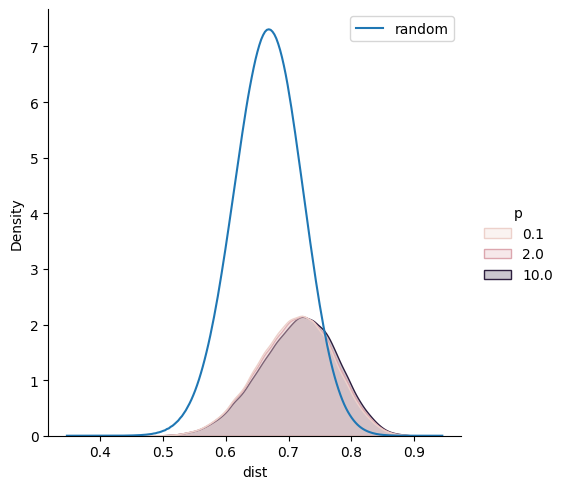

In [ ]:
sns.displot(df, x="dist", hue="p", kind="kde", fill=True)
sns.kdeplot(fingerprints_dist, label="random", bw_adjust=2)  # make more smooth
plt.legend()

Number of neighbors taken into account for repulsion calculation has an effect on the quality:

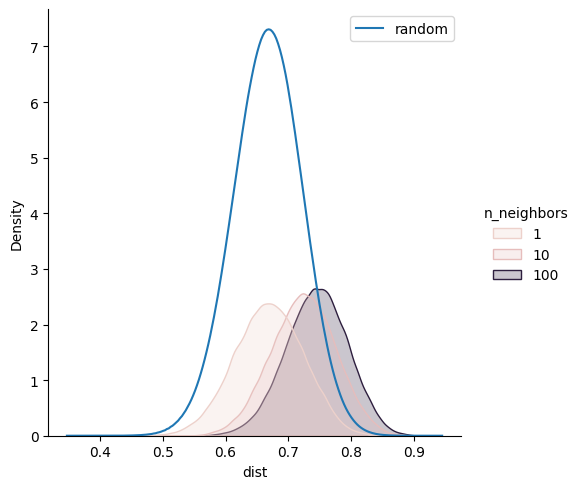

In [ ]:
sns.displot(df, x="dist", hue="n_neighbors", kind="kde", fill=True)
sns.kdeplot(fingerprints_dist, label="random", bw_adjust=2)  # make more smooth
plt.legend()

I suggest to test the algorithm with different `p` and `n_neighbors` values to find the best combination for a particular dataset

- `n_neighbors` must be larger for high-dimensional data.
- `p` larger than 1.0 does not affect the quality of solutions significantly.